# MAD Portfolio Optimization

Portfolio optimization and modern portfolio theory has a long and important history in finance and investment. The principal idea is to find a blend of investments in financial securities that achieves  an optimal trade-off between financial risk and return. The introduction of modern portfolio theory is generally attributed to the 1952 doctoral thesis of [Harry Markowitz](https://en.wikipedia.org/wiki/Harry_Markowitz) who subsequently was award a share of the 1990 Nobel Memorial Prize in Economics for his fundamental contributions to this field. The well-known "Markowitz Model" models measure risk using covariance of the portfolio with respect to constituent assets, then solves a minimum variance problem by quadratic optimization problem subject to constraints to allocate of wealth among assets.

In a [remarkable 1991 paper, Konno and Yamazaki](https://www.jstor.org/stable/2632458?seq=1) proposed a different approach using the mean absolute deviation in portfolio return as a measure of financial risk. The proposed implementation directly incorporates historical price data into a large scale linear programming problem. 

In [1]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.stats as stats

import datetime as datetime

import sys
import os
import glob

import pyomo.environ as pyo

## Download Historical Stock Data

The following cells download daily trading data for a group of the stocks from Yahoo Finance. The trading data is stored in a designated sub-directory (default `./data/stocks/`) as individual `.csv` files for each stock. Subsequent notebooks can read and consolidate the stock price data. 

Run the cells in the notebook once to create data sets for use by other notebook, or to refresh a previously stored set of data. The function will overwrite any existing data sets.

### Installing and Testing `pandas_datareader`

The notebook uses the `pandas_datareader` module to read data from Yahoo Finance. Web interfaces for financial services are notoriously fickle and subject to change, and a particular issue with Google Colaboratory. The following cell tests if `pandas_datareader` installed and functional. It will attempt to upgrade and restart the Python kernel. If you encounter repeated errors please report this as an issue for this notebook. 

In [3]:
# attempt to install. If not found then try install
try:
    import pandas_datareader as pdr
    
except:
    !pip install -q pandas_datareader
    from pandas_datareader import data, wb, DataReader
    
# test download. If fail, then upgrade and restart kernal
try: 
    goog = pdr.DataReader("GOOG", "yahoo")
    print("pandas_datareader is installed and appears to be working correctly.")
except:
    !pip install pandas_datareader --upgrade
    os.kill(os.getpid(), 9)
    

pandas_datareader is installed and appears to be working correctly.


### Stocks to Download

Edit the following cell to download a list of stock symbols from Yahoo Finance,  `n_years` to change the historical period, or change the data directory.

In [4]:
# list of stock symbols
assets = ['AXP', 'AAPL', 'AMGN', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', \
         'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', \
         'MSFT', 'NKE', 'PG','TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 'XOM']

# number of years
n_years = 3.0

# create data directory
data_path = os.path.join('data', 'stocks')
os.makedirs(data_path, exist_ok=True)


### Downloads

Run the following cell to download the historical stock data.

In [5]:
# historical period
end_date = datetime.datetime.today().date()
start_date = end_date - datetime.timedelta(round(n_years*365))

# get daily price data from yahoo finance
def get_stock_data(s, path=data_path):
    try:
        print(f"Downloading {s:6s}", end="")
        data = pdr.DataReader(s, "yahoo", start_date, end_date)
        try:
            filename = os.path.join(path, s + '.csv')
            data.to_csv(filename) 
            print(f" saved to {filename}")
        except: 
            print("save failed")
    except:
        print(f"download failed")      
    
for s in assets:
    get_stock_data(s)
    

## Daily Return and Mean Absolute Deviation of Historical Asset Prices

### Read historical asset prices

The first step in this analysis is to load and consolidate the asset price information into a single DataFrame named `assets`.  The consolidated price information consists of the adjusted closing price reported by Yahoo Finance which includes adjustments for stock splits and dividend distributions.

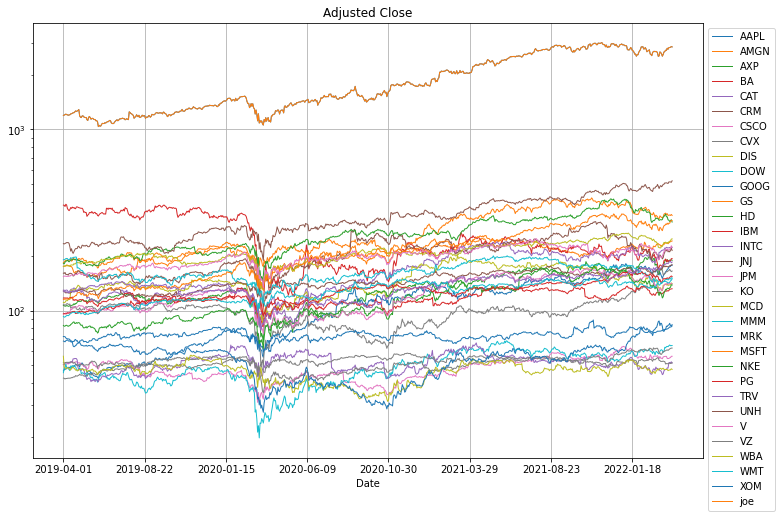

In [6]:
# read historical asset prices

data_path = os.path.join("data", "stocks")
files = glob.glob(os.path.join(data_path, "*.csv"))

assets = pd.DataFrame()
for filename in sorted(files):
    data = pd.read_csv(filename, index_col=0).drop_duplicates()
    sym = filename.split("/")[-1].split(".")[0]
    assets[sym] = data["Adj Close"].drop_duplicates()
    
assets.fillna(method="bfill", inplace=True)
assets.fillna(method="ffill", inplace=True)
    
assets.plot(logy=True, figsize=(12, 8), grid=True, lw=1, title="Adjusted Close")
plt.legend(bbox_to_anchor=(1.0, 1.0))

### Scaled Asset Prices

The historical prices are scaled to a value to have unit value at the start of the historical period. Scaling facilitates plotting and subsequent calculations while preserving arithmetic and logarithmic returns needed for analysis. 

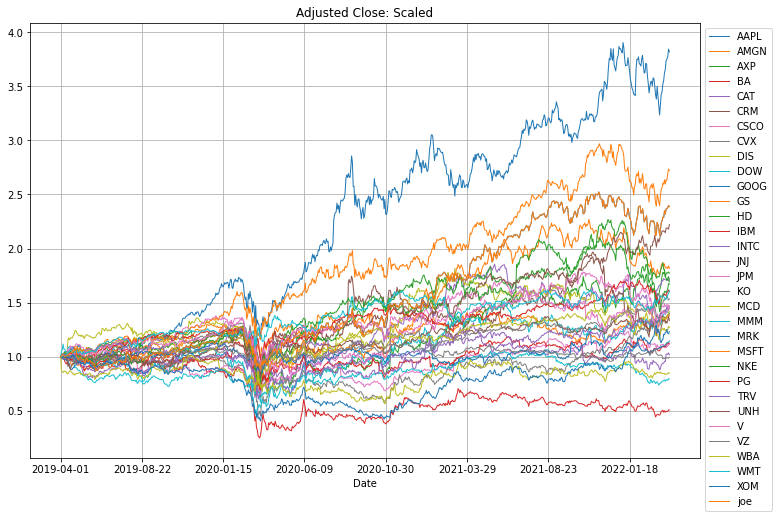

In [7]:
# scaled asset prices
assets_scaled = assets.div(assets.iloc[0])
assets_scaled.plot(figsize=(12, 8), grid=True, lw=1, title="Adjusted Close: Scaled")
plt.legend(bbox_to_anchor=(1.0, 1.0))

### Statistics of Daily Returns

The scaled price of asset $j$ on trading day $t$ is designated $S_{j, i}$. The daily return is computed as

$$r_{j, t} = \frac{S_{j, t} - S_{j, t-1}}{S_{j, t-1}}$$

where $t = 1, \dots, T$. The mean return for asset $j$ is 

$$\bar{r}_j = \frac{1}{T} \sum_{t=1}^T r_{j, t}$$

The following cells compute and display the daily returns for all assets and displays as time series and histograms.

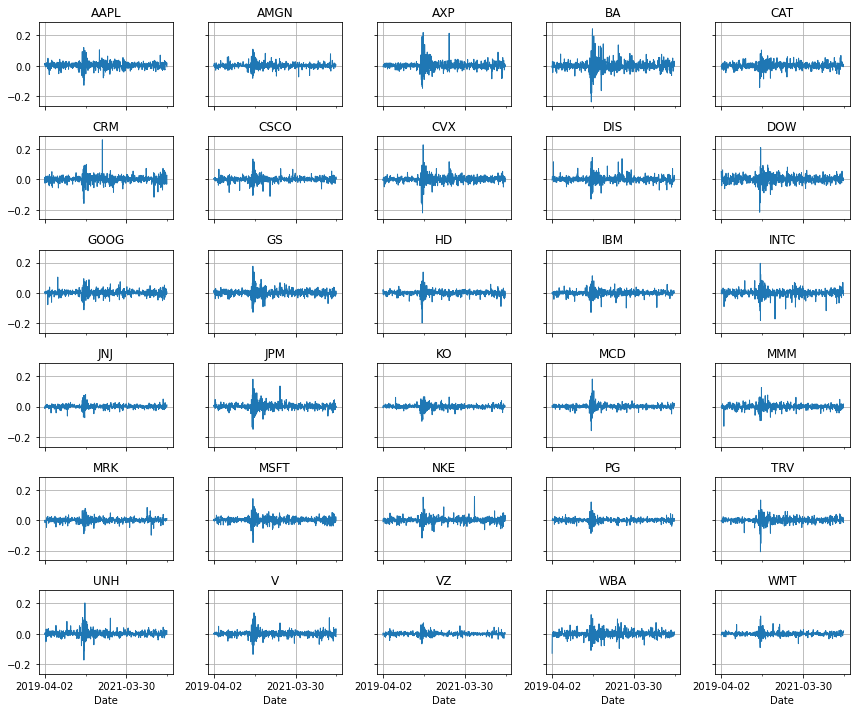

In [8]:
# daily returns
daily_returns = assets.diff()[1:]/assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
for a, s in zip(ax.flatten(), sorted(daily_returns.columns)):
    daily_returns[s].plot(ax=a, lw=1, title=s, grid=True)
plt.tight_layout()

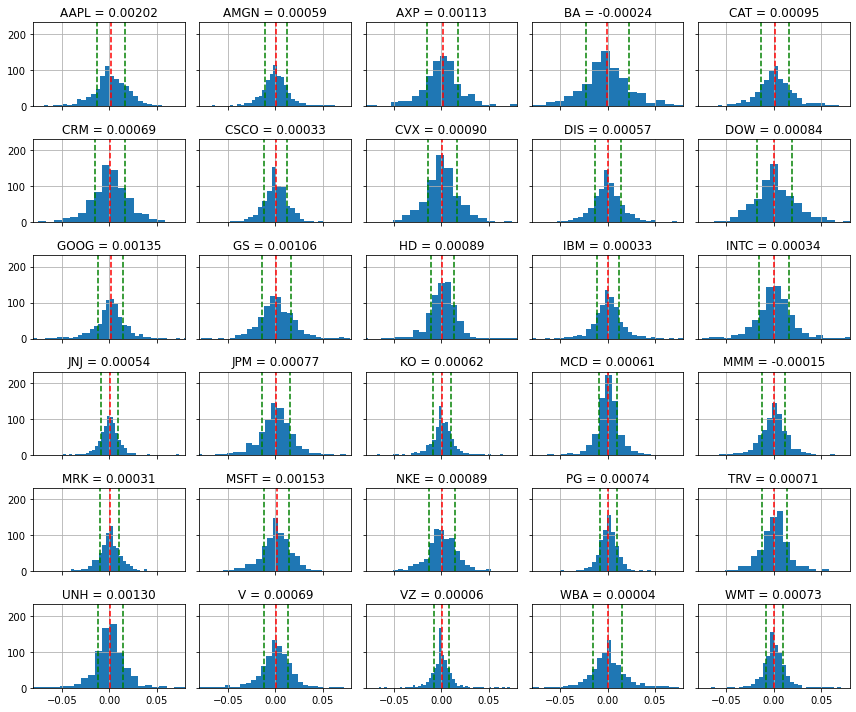

In [9]:
# distributions of returns

daily_returns = assets.diff()[1:]/assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

for a, s in zip(ax.flatten(), daily_returns.columns):
    daily_returns[s].hist(ax=a, lw=1, grid=True, bins=50)
    mean_return = daily_returns[s].mean()
    mean_absolute_deviation = abs((daily_returns[s] - mean_return)).mean()
    a.set_title(f"{s} = {mean_return:0.5f}")
    a.set_xlim(-0.08, 0.08)
    a.axvline(mean_return, color='r', linestyle="--")
    a.axvline(mean_return + mean_absolute_deviation, color='g', linestyle='--')
    a.axvline(mean_return - mean_absolute_deviation, color='g', linestyle='--')
    
plt.tight_layout()

### Mean Absolute Deviation

The mean absolute deviation (MAD) for asset $j$ is 

$$\text{MAD}_j = \frac{1}{T} \sum_{t=1}^T | r_{j,t} - \bar{r}_j |$$

where $T$ is the period under consideration. The mean daily return and the mean absolute deviation in daily return are computed and plotted in the following cell. The side by side comparison provides a comparison of return vs volatility for individual assets.

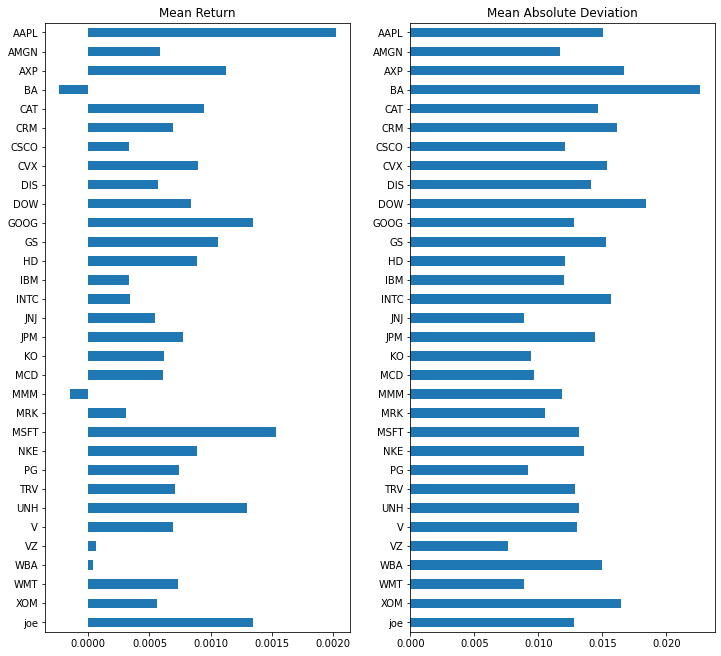

In [10]:
# bar charts of mean return and mean absolute deviation in returns

daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 2, figsize = (12, 0.35*len(daily_returns.columns)))
mean_return.plot(kind='barh', ax=ax[0], title="Mean Return")
ax[0].invert_yaxis()
mean_absolute_deviation.plot(kind='barh', ax=ax[1], title='Mean Absolute Deviation');
ax[1].invert_yaxis()

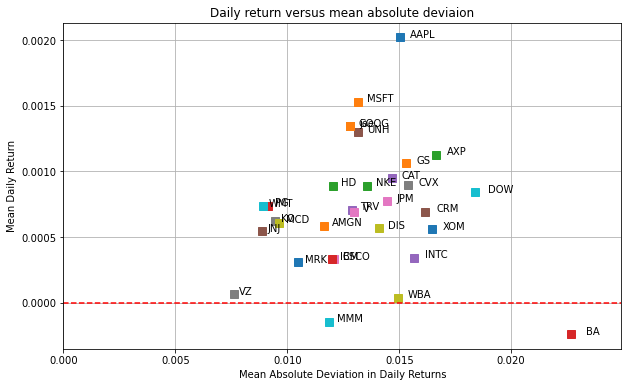

In [11]:
# plot return vs risk
daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10,6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], 's', ms=8)
    ax.text(mean_absolute_deviation[s]*1.03, mean_return[s], s)

ax.set_xlim(0, 1.1*mean_absolute_deviation.max())
ax.axhline(0, color='r', linestyle='--')
ax.set_title('Daily return versus mean absolute deviaion')
ax.set_xlabel('Mean Absolute Deviation in Daily Returns')
ax.set_ylabel('Mean Daily Return')
ax.grid(True)

## Analysis of a Portfolio of Assets

### Return on a portfolio

Given a portfolio with value $W_t$ at time $t$, return on the portfolio at $t_{t +\delta t}$ is defined as

$$
\begin{align*}
r_{t + \delta t} & = \frac{W_{t + \delta t} - W_{t}}{W_{t}}
\end{align*}
$$

For the period from $[t, t+\delta t)$ we assume there are $n_{j,t}$ shares of asset $j$ with a starting value of $S_{j,t}$ per share. The initial and final values of the portfolio are then 

$$
\begin{align*}
W_t & = \sum_{j=1}^J n_{j,t}S_{j,t} \\
W_{t+\delta t} & = \sum_{j=1}^J n_{j,t}S_{j,t + \delta t}
\end{align*}
$$

The return of the portfolio is given by

$$
\begin{align*}
r_{t+\delta t} & = \frac{W_{t + \delta t} - W_{t}}{W_{t}} \\
& = \frac{\sum_{j=1}^Jn_{j,t}S_{j,t+\delta t} - \sum_{j=1}^J n_{j,t}S_{j,t}}{W_{t}} \\
& = \frac{\sum_{j=1}^J n_{j,t}S_{j,t}r_{j, t+\delta t}}{W_{t}} \\
& = \sum_{j=1}^J \frac{n_{j,t}S_{j,t}}{W_{t}} r_{j, t+\delta t}
\end{align*}
$$

where $r_{j,t+\delta t}$ is the return on asset $j$ at time $t+\delta t$. 

Defining $W_{j,t} = n_{j,t}S_{j,t}$ as the wealth invested in asset $j$ at time $t$, then $w_{j,t} = n_{j,t}S_{j,t}/W_{t}$ is the fraction of total wealth invested in asset $j$ at time $t$. The return on a portfolio of $J$ assets is then given by 

$$
\begin{align*}
r_{t+\delta t} & = \sum_{j=1}^J w_{j,t} r_{j, t+\delta t} 
\end{align*}
$$

on a single interval extending from $t$ to $t + \delta t$.

### Mean Absolute Deviation in Portfolio Returns

The return on a portfolio of $J$ assets over a period of $T$ intervals with weights $w_j$ for asset $j$ is given by

$$
\begin{align*}
\text{MAD} & =  \frac{1}{T} \sum_{t=1}^T \left| \sum_{j=1}^J w_{j} (r_{t, j} - \bar{r}_j) \right|
\end{align*}
$$

where $r_{t, j}$ is the return on asset $j$ at time $t$, $\bar{r}_j$ is the mean return for asset $j$, and $w_j$ is the fraction of the total portfolio that is invested in asset $j$. Note that due to the use of absolute values, MAD for the portfolio is *not* the weighted sum of $\text{MAD}_j$ for individual assets

## MAD Portfolio Optimization

The portfolio optimization problem is to find an allocation of investments weights $w_j$ to minimize the portfolio measure of risk subject to constraints on required return and any other constraints an investor wishes to impose. Assume that we can make investment decisions at every trading day $t$ over a fixed time horizon ranging from $t=1,\dots,T$ and that there is a set of $J$ assets in which we can choose to invest."

$$
\begin{align*}
\text{MAD} \qquad \min\ & \frac{1}{T} \sum_{t=1}^T \left| \sum_{j=1}^J w_{j} (r_{t, j} - \bar{r}_j) \right| \\
\\
\sum_{j=1}^J w_j \bar{r}_j  & \geq R \\
\sum_{j=1}^J w_j & = 1 \\
w_j & \geq 0 & \forall j\in 1,\dots, J \\
w_j & \leq w^{ub}_j & \forall j\in 1, \dots, J \\
\end{align*}
$$

where $R$ is the minimum required portfolio return. The lower bound $w_j \geq 0$ is a "no short sales" constraint. The upper bound $w_j \leq w^{ub}_j$ enforces a required level of diversification in the portfolio. 

Defining $u_t \geq 0$ and $v_t \geq 0$ leads to a reformulation of the 

$$
\begin{align*}
\text{MAD} \qquad \min\ & \frac{1}{T} \sum_{t=1}^T (u_t + v_t) \\
\\
u_t - v_t & = \sum_{j=1}^J w_j(r_{t,j} - \bar{r}_j) & \forall t\in 1, \dots, T \\
\sum_{j=1}^J w_j \bar{r}_j  & \geq R \\
\sum_{j=1}^J w_j & = 1 \\
w_j & \geq 0 & \forall j\in 1,\dots, J \\
w_j & \leq w^{ub}_j & \forall j\in 1, \dots, J \\
\end{align*}
$$


## Pyomo Model

Weight lower bounnd                0.000
Weight upper bounnd                0.200
Fraction of portfolio invested     1.000
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00100
Portfolio mean absolute deviation  0.00728


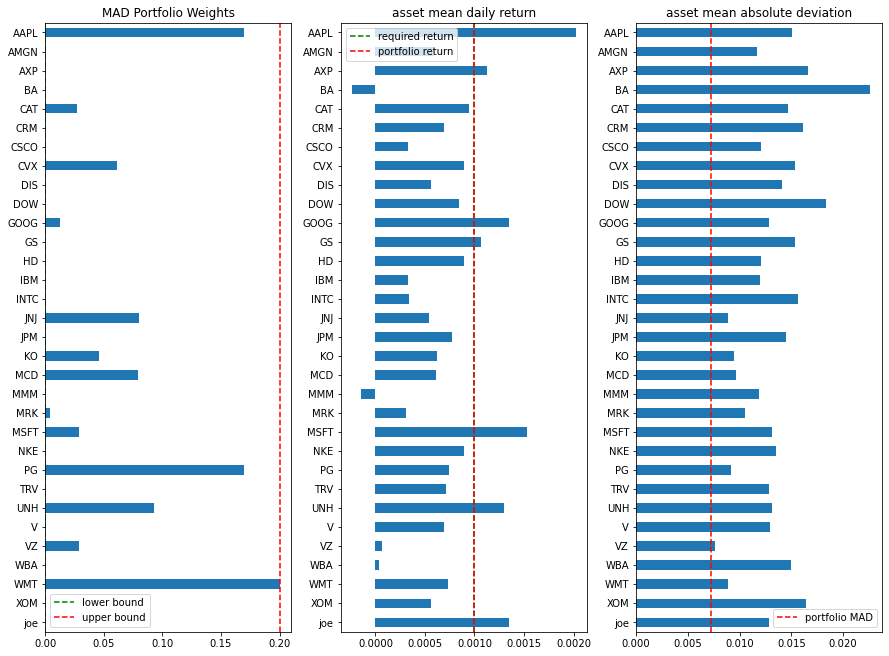

In [12]:
import pyomo.environ as pyo

def mad_portfolio(assets):
    
    daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    m = pyo.ConcreteModel()
    
    m.R = pyo.Param(mutable=True, default=0)
    m.w_lb = pyo.Param(mutable=True, default=0)
    m.w_ub = pyo.Param(mutable=True, default=1.0)
    
    m.ASSETS = pyo.Set(initialize=assets.columns)
    m.TIME = pyo.RangeSet(len(daily_returns.index))
    
    m.w = pyo.Var(m.ASSETS)
    m.u = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    m.v = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.u[t] + m.v[t] for t in m.TIME)/len(m.TIME)
    
    @m.Constraint(m.TIME)
    def portfolio_returns(m, t):
        date = daily_returns.index[t-1]
        return m.u[t] - m.v[t] == sum(m.w[j]*(daily_returns.loc[date, j] - mean_return[j]) for j in m.ASSETS)
    
    @m.Constraint()
    def sum_of_weights(m):
        return sum(m.w[j] for j in m.ASSETS) == 1
    
    @m.Constraint()
    def mean_portfolio_return(m):
        return sum(m.w[j] * mean_return[j] for j in m.ASSETS) >= m.R
    
    @m.Constraint(m.ASSETS)
    def no_short(m, j):
        return m.w[j] >= m.w_lb
    
    @m.Constraint(m.ASSETS)
    def diversify(m, j):
        return m.w[j] <= m.w_ub
    
    return m

def mad_visualization(assets, m):

    print(f"Weight lower bounnd                {m.w_lb():0.3f}")
    print(f"Weight upper bounnd                {m.w_ub():0.3f}")
    print(f"Fraction of portfolio invested     {m.sum_of_weights():0.3f}")
    print(f"Required portfolio daily return    {m.R():0.5f}")
    print(f"Portfolio mean daily return        {m.mean_portfolio_return():0.5f}")
    print(f"Portfolio mean absolute deviation  {m.MAD():0.5f}")

    daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()
    mad_portfolio_weights = pd.DataFrame([m.w[j]() for j in sorted(m.ASSETS)], index=sorted(m.ASSETS))

    fig, ax = plt.subplots(1, 3, figsize = (15, 0.35*len(daily_returns.columns)))
    mad_portfolio_weights.plot(kind='barh', ax=ax[0], title="MAD Portfolio Weights")
    ax[0].invert_yaxis()
    ax[0].axvline(m.w_lb(), ls='--', color='g')
    ax[0].axvline(m.w_ub(), ls='--', color='r')
    ax[0].legend(["lower bound", "upper bound"])

    mean_return.plot(kind='barh', ax=ax[1], title="asset mean daily return")
    ax[1].axvline(m.R(), ls='--', color='g')
    ax[1].axvline(m.mean_portfolio_return(), ls='--', color='r')
    ax[1].invert_yaxis()
    ax[1].legend(['required return', 'portfolio return'])

    mean_absolute_deviation.plot(kind='barh', ax=ax[2], title='asset mean absolute deviation')
    ax[2].axvline(m.MAD(), ls="--", color="r")
    ax[2].legend(["portfolio MAD"])
    ax[2].invert_yaxis()
    
m = mad_portfolio(assets)
m.w_lb = 0
m.w_ub = 0.2
m.R = 0.001
pyo.SolverFactory('cbc').solve(m)
mad_visualization(assets, m)

## MAD Risk versus Return

The portfolio optimization problem has been formulated as the minimization of a risk measure, MAD, subject to a lower bound $R$ on mean portfolio return. Increasing the required return for the portfolio therefore comes at the cost of tolerating a higher level of risk. Finding the optimal trade off between risk and return is a central aspect of any investment strategy.

The following cell creates a plot of the risk/return trade off by solving the MAD portfolio optimization problem for increasing values of required return $R$. This should be compared to the similar construction commonly used in presentations of the portfolio optimization problem due to Markowitz.

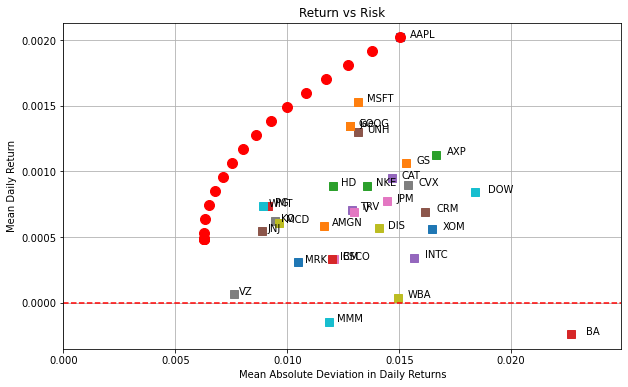

In [13]:
# plot return vs risk
daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10,6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], 's', ms=8)
    ax.text(mean_absolute_deviation[s]*1.03, mean_return[s], s)
    
ax.set_xlim(0, 1.1*max(mean_absolute_deviation))
ax.axhline(0, color='r', linestyle='--')
ax.set_title('Return vs Risk')
ax.set_xlabel('Mean Absolute Deviation in Daily Returns')
ax.set_ylabel('Mean Daily Return')
ax.grid(True)

m = mad_portfolio(assets)
for R in np.linspace(0, mean_return.max(), 20):
    m.R = R
    pyo.SolverFactory('cbc').solve(m)
    mad_portfolio_weights = pd.DataFrame([m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS))

    portfolio_returns = daily_returns.dot(mad_portfolio_weights)
    portfolio_mean_return = portfolio_returns.mean()
    portfolio_mean_absolute_deviation = abs(portfolio_returns - portfolio_mean_return).mean()
    ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, 'ro', ms=10)


## Addition of a Risk-free Asset

The option of a holding a risk-free asset as a component of investment can substantially reduce financial risk. The risk-free asset is designated as $j=0$ with a fixed return $\bar{r}_0$. The fraction invested in asset $j=0$ will be $w_0 = 1 - \sum_{j=1}^J w_j$.

The optimization model becomes

$$
\begin{align*}
\text{MAD} \qquad \min\ & \frac{1}{T} \sum_{t=1}^T \left| \sum_{j=1}^J w_{j} (r_{t, j} - \bar{r}_j) \right| \\
\\
\sum_{j=1}^J w_j (\bar{r}_j - \bar{r}_0)  & \geq R - \bar{r}_0 \\
\sum_{j=1}^J w_j & \leq 1 \\
w_j & \geq 0 & \forall j\in 1,\dots, J \\
w_j & \leq w^{ub}_j & \forall j\in 1, \dots, J \\
\end{align*}
$$

where $R$ is the minimum required portfolio return. The lower bound $w_j \geq 0$ is a "no short sales" constraint. The upper bound $w_j \leq w^{ub}_j$ enforces a required level of diversification in the portfolio. 

Defining $u_t \geq 0$ and $v_t \geq 0$ leads to a reformulation of the 

$$
\begin{align*}
\text{MAD} \qquad \min\ & \frac{1}{T} \sum_{t=1}^T (u_t + v_t) \\
\\
u_t - v_t & = \sum_{j=1}^J w_j(r_{t,j} - \bar{r}_j) & \forall t\in 1, \dots, T \\
\sum_{j=1}^J w_j (\bar{r}_j - \bar{r}_0)  & \geq R - \bar{r}_0 \\
\sum_{j=1}^J w_j & \leq 1 \\
w_j & \geq 0 & \forall j\in 1,\dots, J \\
w_j & \leq w^{ub}_j & \forall j\in 1, \dots, J \\
\end{align*}
$$


Weight lower bounnd                0.000
Weight upper bounnd                0.200
Fraction of portfolio invested     0.744
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00100
Portfolio mean absolute deviation  0.00671


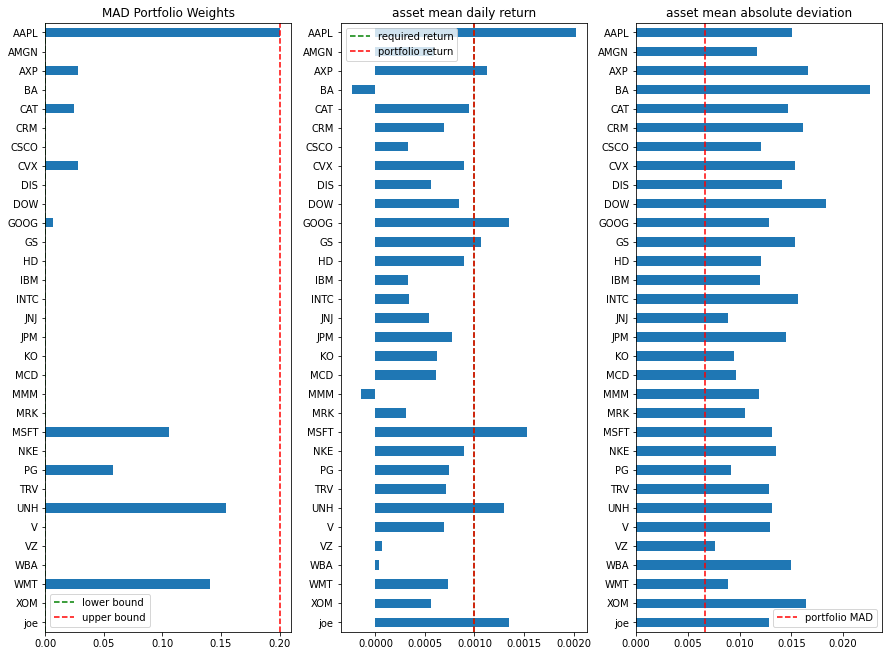

In [14]:
import pyomo.environ as pyo

def mad_portfolio_cash(assets):
    
    daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    m = pyo.ConcreteModel()
    
    m.R = pyo.Param(mutable=True, default=0)
    m.rf = pyo.Param(mutable=True, default=0)
    m.w_lb = pyo.Param(mutable=True, default=0)
    m.w_ub = pyo.Param(mutable=True, default=1.0)
    
    m.ASSETS = pyo.Set(initialize=assets.columns)
    m.TIME = pyo.RangeSet(len(daily_returns.index))
    
    m.w = pyo.Var(m.ASSETS)
    m.u = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    m.v = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.u[t] + m.v[t] for t in m.TIME)/len(m.TIME)
    
    @m.Constraint(m.TIME)
    def portfolio_returns(m, t):
        date = daily_returns.index[t-1]
        return m.u[t] - m.v[t] == sum(m.w[j]*(daily_returns.loc[date, j] - mean_return[j]) for j in m.ASSETS)
    
    @m.Constraint()
    def sum_of_weights(m):
        return sum(m.w[j] for j in m.ASSETS) <= 1
    
    @m.Constraint()
    def mean_portfolio_return(m):
        return sum(m.w[j] * (mean_return[j] - m.rf) for j in m.ASSETS) >= m.R - m.rf
    
    @m.Constraint(m.ASSETS)
    def no_short(m, j):
        return m.w[j] >= m.w_lb
    
    @m.Constraint(m.ASSETS)
    def diversify(m, j):
        return m.w[j] <= m.w_ub
    
    return m

def mad_visualization(assets, m):

    print(f"Weight lower bounnd                {m.w_lb():0.3f}")
    print(f"Weight upper bounnd                {m.w_ub():0.3f}")
    print(f"Fraction of portfolio invested     {m.sum_of_weights():0.3f}")
    print(f"Required portfolio daily return    {m.R():0.5f}")
    print(f"Portfolio mean daily return        {m.mean_portfolio_return():0.5f}")
    print(f"Portfolio mean absolute deviation  {m.MAD():0.5f}")

    daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()
    mad_portfolio_weights = pd.DataFrame([m.w[j]() for j in sorted(m.ASSETS)], index=sorted(m.ASSETS))

    fig, ax = plt.subplots(1, 3, figsize = (15, 0.35*len(daily_returns.columns)))
    mad_portfolio_weights.plot(kind='barh', ax=ax[0], title="MAD Portfolio Weights")
    ax[0].invert_yaxis()
    ax[0].axvline(m.w_lb(), ls='--', color='g')
    ax[0].axvline(m.w_ub(), ls='--', color='r')
    ax[0].legend(["lower bound", "upper bound"])

    mean_return.plot(kind='barh', ax=ax[1], title="asset mean daily return")
    ax[1].axvline(m.R(), ls='--', color='g')
    ax[1].axvline(m.mean_portfolio_return(), ls='--', color='r')
    ax[1].invert_yaxis()
    ax[1].legend(['required return', 'portfolio return'])

    mean_absolute_deviation.plot(kind='barh', ax=ax[2], title='asset mean absolute deviation')
    ax[2].axvline(m.MAD(), ls="--", color="r")
    ax[2].legend(["portfolio MAD"])
    ax[2].invert_yaxis()
    
m = mad_portfolio_cash(assets)
m.w_lb = 0
m.w_ub = 0.2
m.R = 0.001
pyo.SolverFactory('cbc').solve(m)
mad_visualization(assets, m)

## MAD Risk versus return with a risk-free asset 

As above, it is instructive to plot the MAD risk versus required return $R$. The result is similar, but not exactly the same, as  the standard presentation from modern portfolio theory (MPT) for efficient frontier of investing, and the capital market line. A careful look at the the plot below shows minor difference at very high levels of return and risk that departs from the MPT analysis. 

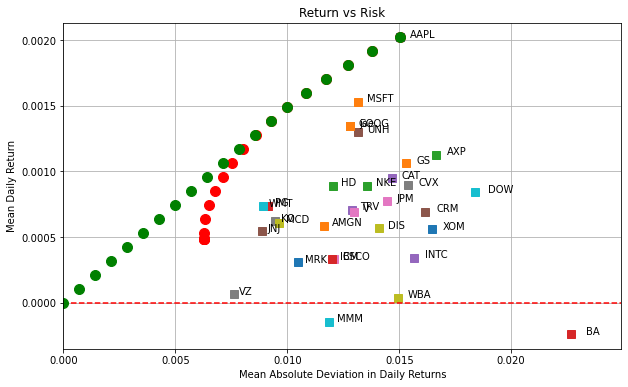

In [15]:
# plot return vs risk
daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10,6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], 's', ms=8)
    ax.text(mean_absolute_deviation[s]*1.03, mean_return[s], s)
    
ax.set_xlim(0, 1.1*max(mean_absolute_deviation))
ax.axhline(0, color='r', linestyle='--')
ax.set_title('Return vs Risk')
ax.set_xlabel('Mean Absolute Deviation in Daily Returns')
ax.set_ylabel('Mean Daily Return')
ax.grid(True)

for color, m in zip(['ro', 'go'], [mad_portfolio(assets), mad_portfolio_cash(assets)]):
    for R in np.linspace(0, mean_return.max(), 20):
        m.R = R
        pyo.SolverFactory('cbc').solve(m)
        mad_portfolio_weights = pd.DataFrame([m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS))
        portfolio_returns = daily_returns.dot(mad_portfolio_weights)
        portfolio_mean_return = portfolio_returns.mean()
        portfolio_mean_absolute_deviation = abs(portfolio_returns - portfolio_mean_return).mean()
        ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, color, ms=10)
